In [1]:
import os
import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy
from utils._bootstrap import bootstrap, CONF
import sympy

VAR_NAME = "D-CIPHER"
MSE_NAME = "Abl. D-CIPHER"

In [2]:
def combine(equation, var_or_mse):
    meta_reg = os.path.join(equation,var_or_mse,'*.p')
    meta_files = glob.glob(meta_reg)
    csv_files = [file.split('_meta.p')[0]+'_table.csv' for file in meta_files]
    dfs = []
    for meta_file, csv_file in zip(meta_files,csv_files):
        df = pd.read_csv(csv_file)
        with open(meta_file, 'rb') as f:
            setting = pickle.load(f)
            args = setting['arguments']
            gp_config = setting['gp_config']
            df['name'] = args.name
            df['filed_index'] = args.field_index
            df['width'] = args.width
            df['frequency_per_dim'] = args.frequency_per_dim
            df['noise_ratio'] = args.noise_ratio

            if var_or_mse == 'var':
                df['full_grid_samples'] = args.full_grid_samples
                df['max_ind_basis'] = args.max_ind_basis
                df['basis'] = args.basis
            elif var_or_mse == 'mse':
                df['diff_engine'] = args.diff_engine

            df['conditions_set'] = args.conditions_set
            df['num_trials'] = args.num_trials
            df['normalization'] = args.normalization
            df['solver'] = args.solver
            df['global_seed'] = args.seed
            df['num_samples'] = args.num_samples
            df['source'] = setting['table']
            for key in gp_config.keys():
                if key not in ['function_set']:
                    df[key] = gp_config[key]
        dfs.append(df)    
    full_df = pd.concat(dfs,ignore_index=True)
    full_df.drop(columns=['Unnamed: 0'],inplace=True)
    return full_df

In [3]:
def filter_df(df, filter_dict):
    mask_list = [df[key]==filter_dict[key] for key in filter_dict.keys()]
    global_mask = np.all(mask_list,axis=0)
    return df[global_mask]
    

In [4]:
# This function generates all equivalent functional forms of the given equation based on the given substitution dictionary as in Appendix E.8

X0,X1,X2,X3 = sympy.symbols('X0,X1,X2,X3',real=True)
C,C0,C1,C2,C3,C4,C5 = sympy.symbols('C,C0,C1,C2,C3,C4,C5')

import itertools
def generate_expr_list(f,sub_dict):
    keys, values = zip(*sub_dict.items())
    sub_variant_list = [dict(zip(keys, v)) for v in itertools.product(*values)]
    expr_list = []
    for sub_variant in sub_variant_list:
        g = f
        for key in sub_variant.keys():
            g = g.subs(key,sub_variant[key])
        expr_list.append(str(g))
    return expr_list


In [5]:
# Most equations are checked for correctness by the program but some may be miscategorized.
# This function allows for checking the correctness of equations according th the definition in Appendix E.8

def evaluate_correct(df, exprs, verbose=False):
    new_df = df.copy()
    for index, row in new_df.iterrows():
        truth_list = []
        eqC = row['eqC']
        for expr in exprs:
            truth_list.append(eqC == expr)
        if np.sum(truth_list) > 0:
            if (new_df.loc[index,'is_correct'] == False) and verbose:
                print(f"Changed to true: {eqC}")
            new_df.loc[index,'is_correct'] = True
        else:
            if (new_df.loc[index,'is_correct'] == True) and verbose:
                print(f"Changed to false: {eqC}")
            new_df.loc[index,'is_correct'] = False
    return new_df

In [6]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
linewidth = 2.0
markersize = 10.0
def plot_success(ax, var_df, mse_df, by, conf, default_dict = {'noise_ratio':0.01,'num_samples':10,'delta_t':0.1, 'global_seed':2}):
    new_dict = default_dict.copy()
    new_dict.pop(by, None)
    var = filter_df(var_df,new_dict).groupby(by)['is_correct']
    mse = filter_df(mse_df,new_dict).groupby(by)['is_correct']
    z = norm.ppf(1 - (1-conf)/2)
    var_int = list(z*np.sqrt((var.mean() * (1-var.mean()))/var.count()))
    mse_int = list(z*np.sqrt((mse.mean() * (1-mse.mean()))/mse.count()))
    ax.plot(var.mean().index,var.mean(),'o-',label=VAR_NAME,color=CB_color_cycle[0],markersize=markersize,linewidth=linewidth)
    ax.fill_between(var.mean().index,var.mean()-var_int,var.mean()+var_int,alpha=0.3,color=CB_color_cycle[0])
    
    ax.plot(mse.mean().index,mse.mean(),'o-',label=MSE_NAME,color=CB_color_cycle[1],markersize=markersize,linewidth=linewidth)
    ax.fill_between(mse.mean().index,mse.mean()-mse_int,mse.mean()+mse_int,alpha=0.3,color=CB_color_cycle[1])
    
#     print(var.mean())
#     print(var_int)
#     print(mse.mean())
#     print(mse_int)
    
def plot_operator_difference_bootstrap(ax,var_df, mse_df, by,conf,num_operators, signs, default_dict = {'noise_ratio':0.01,'num_samples':10,'delta_t':0.1, 'global_seed':2}):
    
    new_dict = default_dict.copy()
    new_dict.pop(by, None)
    found_operator_columns = [f"operator_{i}" for i in range(num_operators)]

    target_operator_columns = [f"target_weights_{i}" for i in range(num_operators)]
    var_f = filter_df(var_df,new_dict).copy()
    mse_f = filter_df(mse_df,new_dict).copy()
    
    var_f['diff'] = 0.0
    for i in range(num_operators):
        var_f['diff'] += (var_f[f'operator_{i}'] - signs[i]*var_f[f'target_weights_{i}']) ** 2
    var_f['diff'] = np.sqrt(var_f['diff']/num_operators)
    mse_f['diff'] = 0.0
    for i in range(num_operators):
        mse_f['diff'] += (mse_f[f'operator_{i}'] - mse_f[f'target_weights_{i}']) ** 2
    mse_f['diff'] = np.sqrt(mse_f['diff']/num_operators)
    
    var = var_f
    mse = mse_f

    params = var[by].unique()
    params.sort()
    
    var_ints = [bootstrap(var.loc[var[by] == param,'diff'].to_numpy(float).reshape(1,-1),np.mean,vectorized=True,confidence_level=conf).confidence_interval for param in params]
    var_stds = [bootstrap(var.loc[var[by] == param,'diff'].to_numpy(float).reshape(1,-1),np.mean,vectorized=True,confidence_level=conf).standard_error for param in params]
    
    var_lows = [i.low for i in var_ints]
    var_highs = [i.high for i in var_ints]
    
    var_means = var.groupby(by)['diff'].mean()
    ax.plot(params,var_means.loc[params],'o-',label=VAR_NAME,color=CB_color_cycle[0],markersize=markersize,linewidth=linewidth)
    ax.fill_between(params,var_lows,var_highs,alpha=0.3,color=CB_color_cycle[0])
    
    mse_ints = [bootstrap(mse.loc[mse[by] == param,'diff'].to_numpy(float).reshape(1,-1),np.mean,vectorized=True,confidence_level=conf).confidence_interval for param in params]
    mse_stds = [bootstrap(mse.loc[mse[by] == param,'diff'].to_numpy(float).reshape(1,-1),np.mean,vectorized=True,confidence_level=conf).standard_error for param in params]
    
    mse_lows = [i.low for i in mse_ints]
    mse_highs = [i.high for i in mse_ints]
    
    mse_means = mse.groupby(by)['diff'].mean()
    ax.plot(params,mse_means.loc[params],'o-',label=MSE_NAME,color=CB_color_cycle[1],markersize=markersize,linewidth=linewidth)
    ax.fill_between(params,mse_lows,mse_highs,alpha=0.3,color=CB_color_cycle[1])

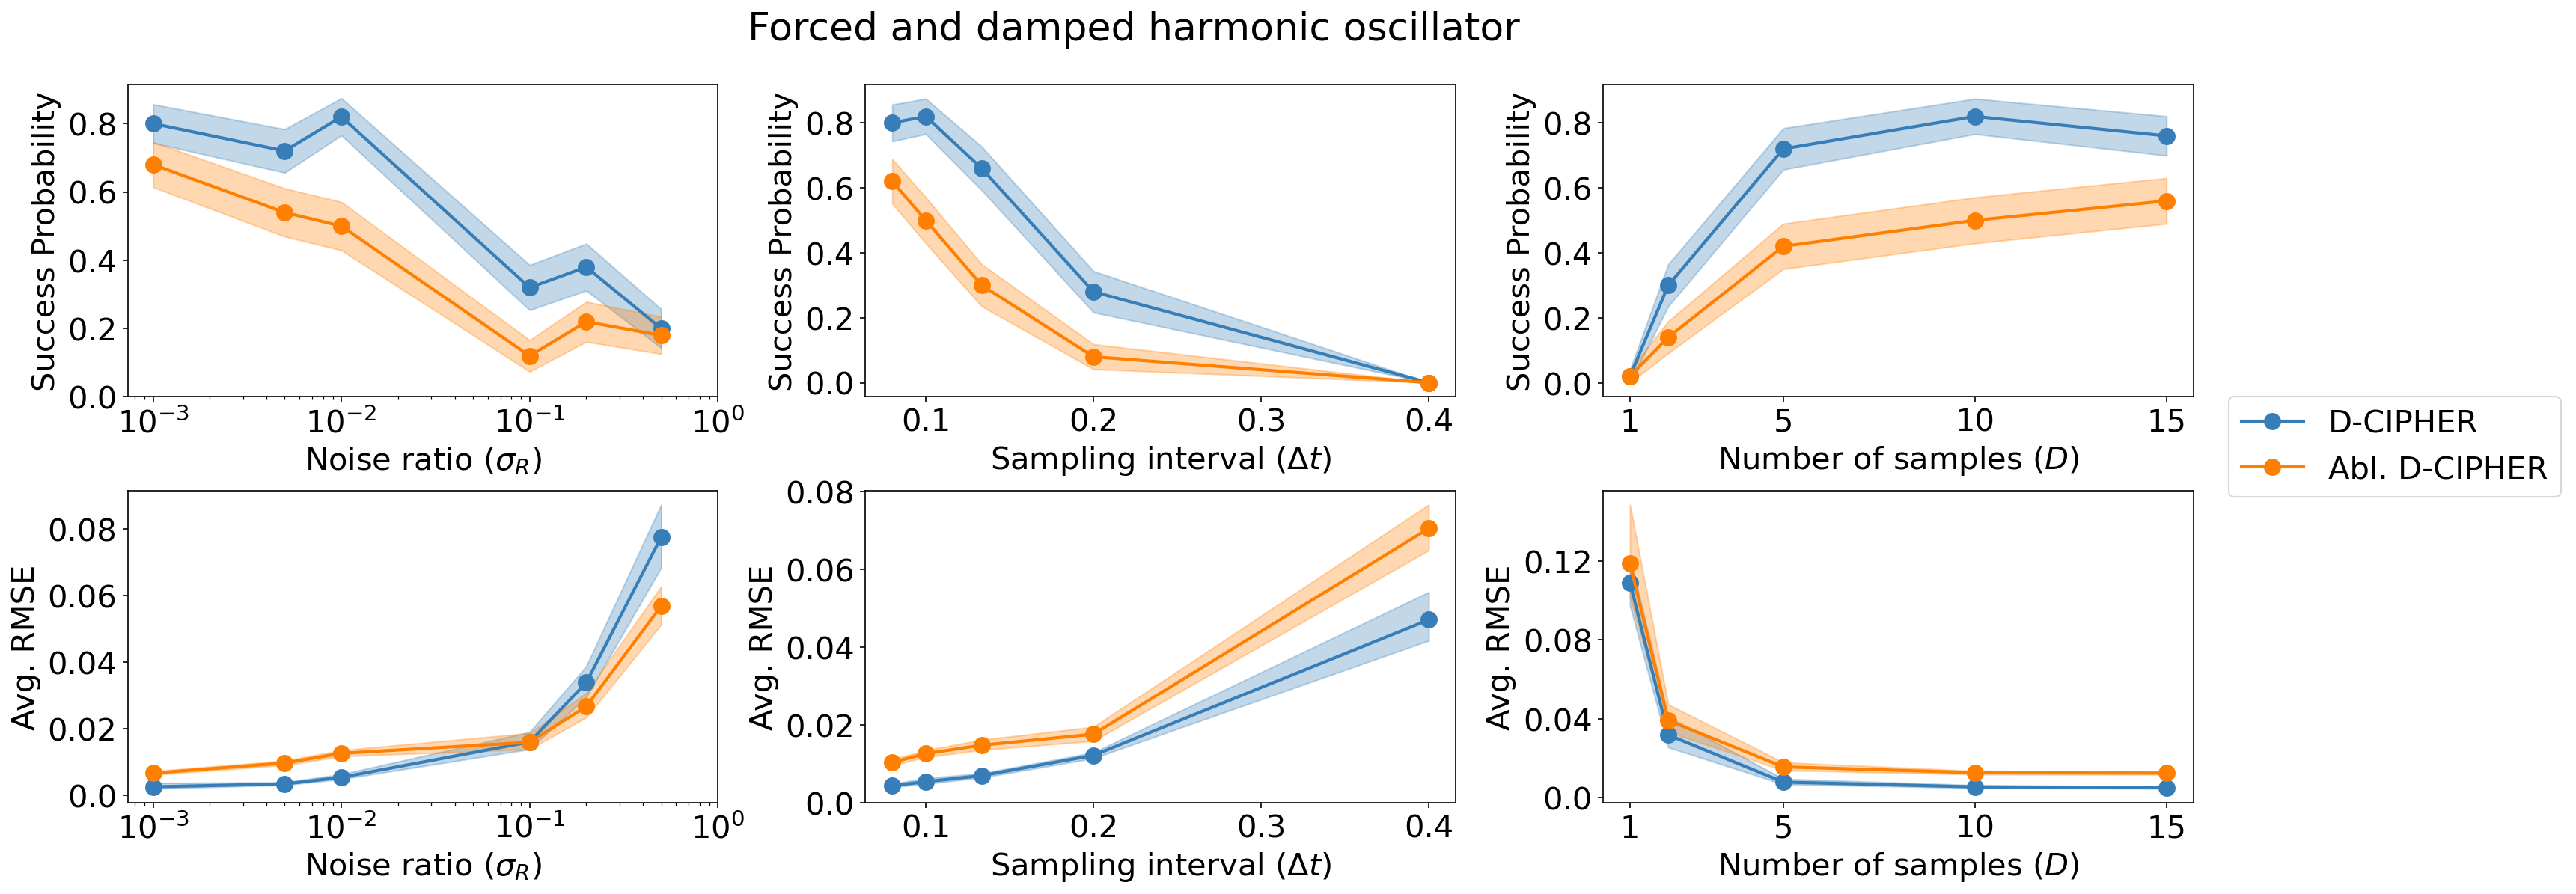

In [7]:
xlabel_fontsize = 20
ylabel_fontsize = 20
title_fontsize = 25
legend_fontsize = 20
ticks_fontsize = 20

var_df = combine("../results/ForcedHarmonicOscillator",'var')
mse_df = combine("../results/ForcedHarmonicOscillator",'mse')

noise_start = 0.001
noise_end = 0.5
var_df = var_df[(var_df['noise_ratio'] >= noise_start) & (var_df['noise_ratio'] <= noise_end)]
mse_df = mse_df[(mse_df['noise_ratio'] >= noise_start) & (mse_df['noise_ratio'] <= noise_end)]
time_horizon = 2.0
var_df['delta_t'] = time_horizon / var_df['frequency_per_dim'] 
mse_df['delta_t'] = time_horizon / mse_df['frequency_per_dim']

f = -C0*X1 + C1*sympy.sin(C2*X0+C3)+C4
sub_dict = {
    C0:[1,C],
    C1:[1,C],
    C2:[1,C],
    C3:[0,C,-C],
    C4:[0,C,-C]
}

expr_list = generate_expr_list(f,sub_dict)

var_df = evaluate_correct(var_df,expr_list)
mse_df = evaluate_correct(mse_df,expr_list)

# An exception as sin(x+pi) = -sin(x)
mse_df.loc[mse_df['eqC']=='-C*X1 - sin(C*X0 - C)','is_correct'] = True
var_df.loc[var_df['eqC']=='-C*X1 - sin(C*X0 - C)','is_correct'] = True

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,figsize=(23,8),dpi=150)

plot_success(ax1,var_df, mse_df,'noise_ratio',CONF)
ax1.set_xscale('log')
ax1.set_xlabel(r'Noise ratio ($\sigma_R$)', fontsize=xlabel_fontsize)
ax1.set_ylabel('Success Probability', fontsize=ylabel_fontsize)
ax1.set_yticks([0.0,0.2,0.4,0.6,0.8])
ax1.set_yticklabels([0.0,0.2,0.4,0.6,0.8], fontsize=ticks_fontsize)
ax1.set_xticks([0.001,0.01,0.1,1])
ax1.set_xticklabels(['$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$'], fontsize=ticks_fontsize)


plot_success(ax2,var_df, mse_df,'delta_t',CONF)
ax2.set_xlabel(r'Sampling interval ($\Delta t$)', fontsize=xlabel_fontsize)
ax2.set_ylabel('Success Probability', fontsize=ylabel_fontsize)
ax2.set_yticks([0.0,0.2,0.4,0.6,0.8])
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8], fontsize=ticks_fontsize)
ax2.set_xticks([0.1,0.2,0.3,0.4])
ax2.set_xticklabels([0.1,0.2,0.3,0.4], fontsize=ticks_fontsize)


plot_success(ax3,var_df, mse_df,'num_samples',CONF)
ax3.set_xlabel('Number of samples ($D$)', fontsize=xlabel_fontsize)
ax3.set_ylabel('Success Probability', fontsize=ylabel_fontsize)
ax3.set_yticks([0.0,0.2,0.4,0.6,0.8])
ax3.set_yticklabels([0.0,0.2,0.4,0.6,0.8], fontsize=ticks_fontsize)
ax3.set_xticks([1,5,10,15])
ax3.set_xticklabels([1,5,10,15], fontsize=ticks_fontsize)

plot_operator_difference_bootstrap(ax4,var_df, mse_df,'noise_ratio',CONF,2,[-1,1])
ax4.set_xscale('log')
ax4.set_xlabel(r'Noise ratio ($\sigma_R$)', fontsize=xlabel_fontsize)
ax4.set_ylabel('Avg. RMSE', fontsize=ylabel_fontsize)
ax4.set_xticks([0.001,0.01,0.1,1])
ax4.set_xticklabels(['$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$'], fontsize=ticks_fontsize)
ax4.set_yticks([0.00,0.02,0.04,0.06,0.08])
ax4.set_yticklabels([0.00,0.02,0.04,0.06,0.08], fontsize=ticks_fontsize)

plot_operator_difference_bootstrap(ax5,var_df, mse_df,'delta_t',CONF,2,[-1,1])
ax5.set_xlabel(r'Sampling interval ($\Delta t$)', fontsize=xlabel_fontsize)
ax5.set_ylabel('Avg. RMSE', fontsize=ylabel_fontsize)
ax5.set_xticks([0.1,0.2,0.3,0.4])
ax5.set_xticklabels([0.1,0.2,0.3,0.4], fontsize=ticks_fontsize)
ax5.set_yticks([0.00,0.02,0.04,0.06,0.08])
ax5.set_yticklabels([0.00,0.02,0.04,0.06,0.08], fontsize=ticks_fontsize)

plot_operator_difference_bootstrap(ax6,var_df, mse_df,'num_samples',CONF,2,[-1,1])
ax6.set_xlabel('Number of samples ($D$)', fontsize=xlabel_fontsize)
ax6.set_ylabel('Avg. RMSE', fontsize=ylabel_fontsize)
ax6.set_xticks([1,5,10,15])
ax6.set_xticklabels([1,5,10,15], fontsize=ticks_fontsize)
ax6.set_yticks([0.00,0.04,0.08,0.12])
ax6.set_yticklabels([0.00,0.04,0.08,0.12], fontsize=ticks_fontsize)


# fig.suptitle("Forced and damped harmonic oscillator", fontsize=title_fontsize)
fig.text(0.29, 0.95, "Forced and damped harmonic oscillator", fontsize=title_fontsize)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels,loc='center right',fontsize=legend_fontsize)

plt.subplots_adjust(left=0.05,
                    bottom=0.1, 
                    right=0.85, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.3)
plt.savefig("figures/Figure_4.pdf",dpi=fig.dpi)
plt.show()
